In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
data =pd.read_csv("/content/drive/MyDrive/Final_dataset/Total_energy_csv.csv")

In [ ]:
import pandas as pd
d=pd.read_csv('/content/drive/MyDrive/Final_dataset/Total_energy_csv.csv')
d.columns


Index(['Date', 'East_Campus ', 'MBA_&_MCA', 'Civil ', 'Mech', 'Auto ',
       'Total'],
      dtype='object')

In [ ]:
date=d['Date']
total=d['Total']
df=pd.DataFrame({"Date":date,"Total_consumption":total})
df

,Date,Total_consumption
0,19.10.2023,11187
1,20.10.2023,11456
2,21.10.2023,12995
3,22.10.2023,10636
4,23.10.2023,10165
...,...,...
186,22.04.2024,12433
187,23.04.2024,8915
188,24.04.2024,12151
189,25.04.2024,12527


In [ ]:

df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()


<ipython-input-8-817f22e23f22>:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Consumption
Date,
2023-10-19,11187
2023-10-20,11456
2023-10-21,12995
2023-10-22,10636
2023-10-23,10165


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #perform dickey fuller test
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df)

Results of dickey fuller test
Test Statistics               -1.041264e+01
p-value                        1.787549e-18
No. of lags used               0.000000e+00
Number of observations used    1.900000e+02
critical value (1%)           -3.465244e+00
critical value (5%)           -2.876875e+00
critical value (10%)          -2.574945e+00
dtype: float64


In [ ]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(df_log_moving_avg_diff)

Results of dickey fuller test
Test Statistics               -6.009149e+00
p-value                        1.588801e-07
No. of lags used               1.400000e+01
Number of observations used    1.650000e+02
critical value (1%)           -3.470616e+00
critical value (5%)           -2.879221e+00
critical value (10%)          -2.576197e+00
dtype: float64


In [ ]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
print(weighted_average.head())

            Consumption
Date                   
2023-10-19     9.322508
2023-10-20     9.334731
2023-10-21     9.383267
2023-10-22     9.352996
2023-10-23     9.324739


In [ ]:
df_log_diff = df_log - df_log.shift()

In [ ]:
df_log_diff.dropna(inplace=True)

In [ ]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')

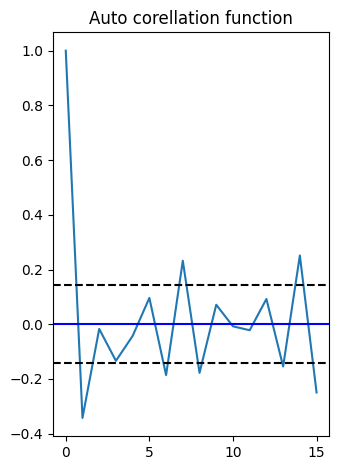

In [ ]:
plt.subplot(121)
plt.plot(acf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()

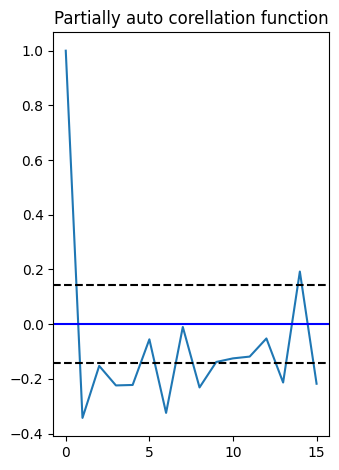

In [ ]:
plt.subplot(122)
plt.plot(pacf)
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

RSS : nan


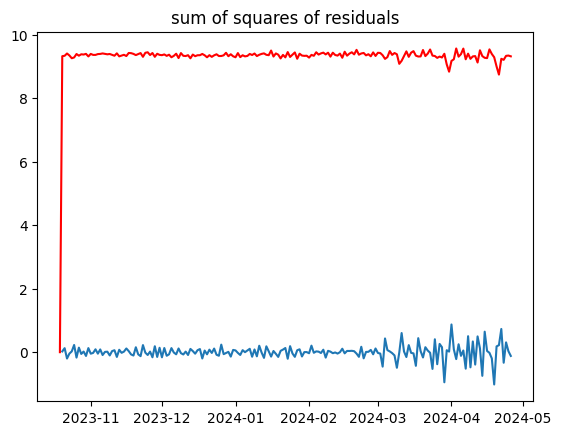

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit()
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
#plt.legend()
plt.show(block =False)

Date
2023-10-19     0.000000
2023-10-20     9.322507
2023-10-21    18.658082
2023-10-22    28.065007
2023-10-23    37.410630
dtype: float64
Date
2023-10-19     9.322508
2023-10-20    18.668776
2023-10-21    28.130402
2023-10-22    37.337007
2023-10-23    46.637336
dtype: float64


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


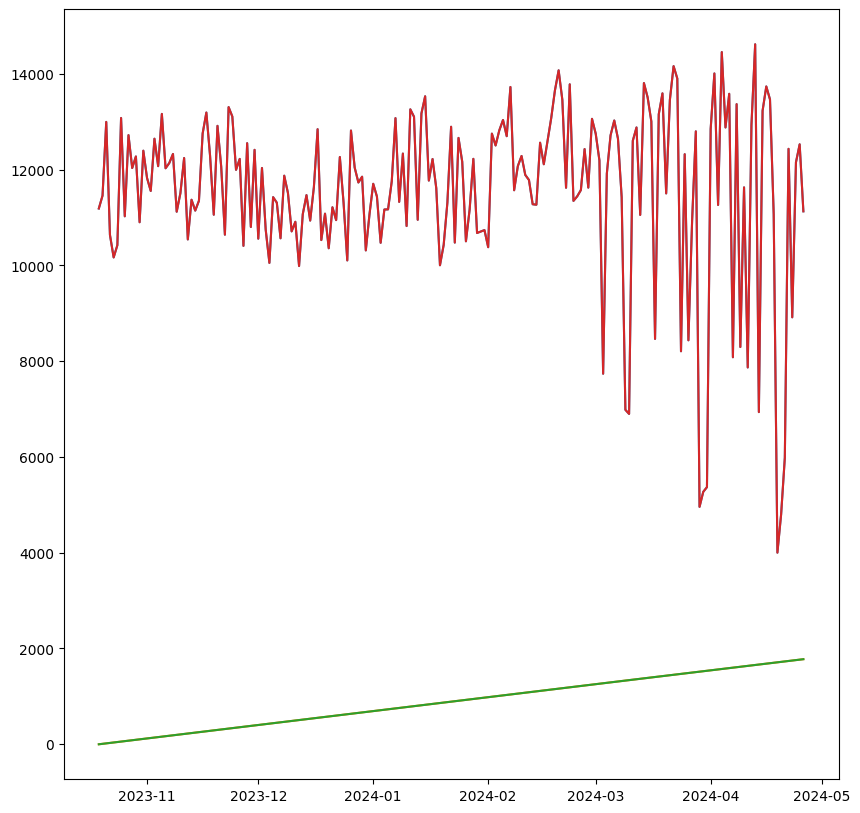

In [ ]:

ARIMA_predicts = pd.Series(result_AR.fittedvalues,copy=True)
ARIMA_predicts.head()

# finding the cummulative sum
ARIMA_predicts_cumsum = ARIMA_predicts.cumsum()
print(ARIMA_predicts_cumsum.head())


ARIMA_predicts_log = pd.Series(df_log['Consumption'],index = df_log.index)
ARIMA_predicts_log = ARIMA_predicts_log.add(ARIMA_predicts_cumsum,fill_value=0)
print(ARIMA_predicts_log.head())

# converting back to the exponential form results in getting back to the original data.
ARIMA_final_preditcs = np.exp(ARIMA_predicts_log)
rcParams['figure.figsize']=10,10
plt.plot(df)
plt.plot(ARIMA_predicts_cumsum)

plt.plot(ARIMA_predicts_cumsum)
plt.plot(df)


Forecasted energy consumption for the next 10 days:
2024-04-27    9.468293
2024-04-28    9.214626
2024-04-29    9.466601
2024-04-30    9.249786
2024-05-01    9.374211
2024-05-02    9.363439
2024-05-03    9.257682
2024-05-04    9.454018
2024-05-05    9.211081
2024-05-06    9.446367
Freq: D, Name: predicted_mean, dtype: float64


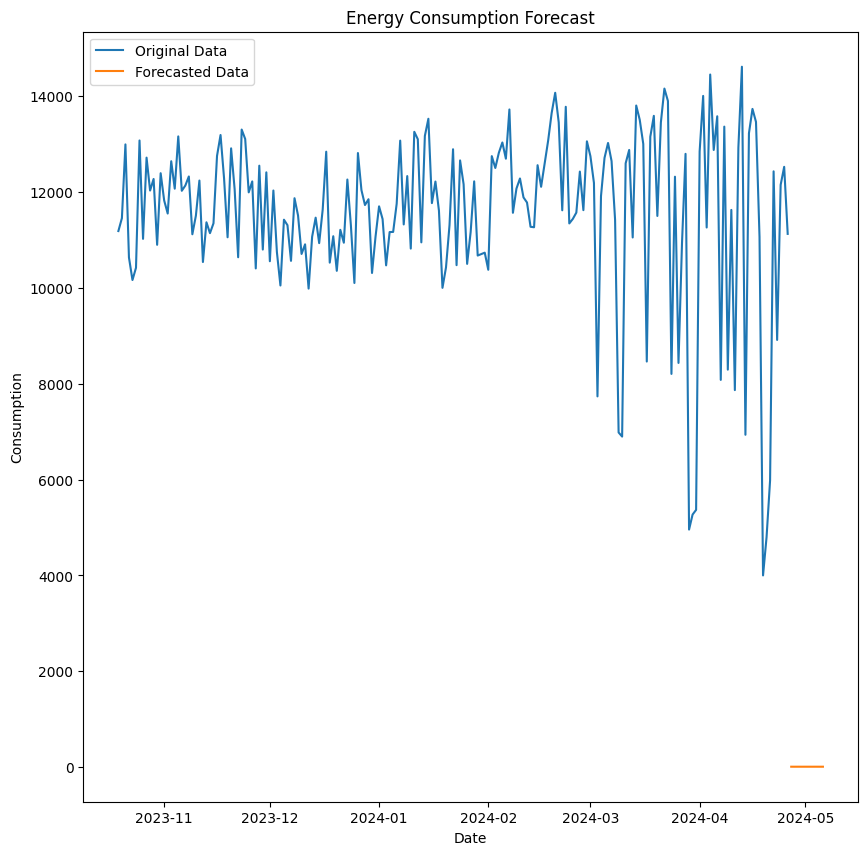

In [ ]:
# Forecasting the next 10 days
forecast_steps = 10
forecast = result_AR.forecast(steps=forecast_steps)

# Display the forecasted values
print("Forecasted energy consumption for the next 10 days:")
print(forecast)

# Plot the original data and the forecasted values
plt.plot(df.index, df['Consumption'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Energy Consumption Forecast')
plt.legend()
plt.show()


In [ ]:
# Fit ARIMA model to the original data
model = ARIMA(df, order=(3, 1, 3))
result_AR = model.fit()

# Forecast the next 10 days
forecast_steps = 30
forecast = result_AR.forecast(steps=forecast_steps)
forecast_rounded = forecast.round()
# Display the forecasted values
print("Forecasted energy consumption for the next 10 days:")
print(forecast_rounded)

# Plot the original data and the forecasted values



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Forecasted energy consumption for the next 10 days:
2024-04-27    12188.0
2024-04-28    10581.0
2024-04-29    12326.0
2024-04-30    10826.0
2024-05-01    11744.0
2024-05-02    11599.0
2024-05-03    10956.0
2024-05-04    12223.0
2024-05-05    10633.0
2024-05-06    12180.0
2024-05-07    11023.0
2024-05-08    11539.0
2024-05-09    11765.0
2024-05-10    10866.0
2024-05-11    12219.0
2024-05-12    10727.0
2024-05-13    12018.0
2024-05-14    11214.0
2024-05-15    11362.0
2024-05-16    11888.0
2024-05-17    10823.0
2024-05-18    12174.0
2024-05-19    10848.0
2024-05-20    11851.0
2024-05-21    11389.0
2024-05-22    11219.0
2024-05-23    11968.0
2024-05-24    10823.0
2024-05-25    12096.0
2024-05-26    10984.0
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
  from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Forecast the energy consumption using the trained ARIMA model
forecast = result_AR.forecast(steps=len(df))  # Forecast for the entire dataset

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df['Consumption'], forecast)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(df['Consumption'], forecast)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Display the accuracy metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 1289.976959637807
Mean Squared Error (MSE): 3329981.7779471027
Root Mean Squared Error (RMSE): 1824.8237662708973


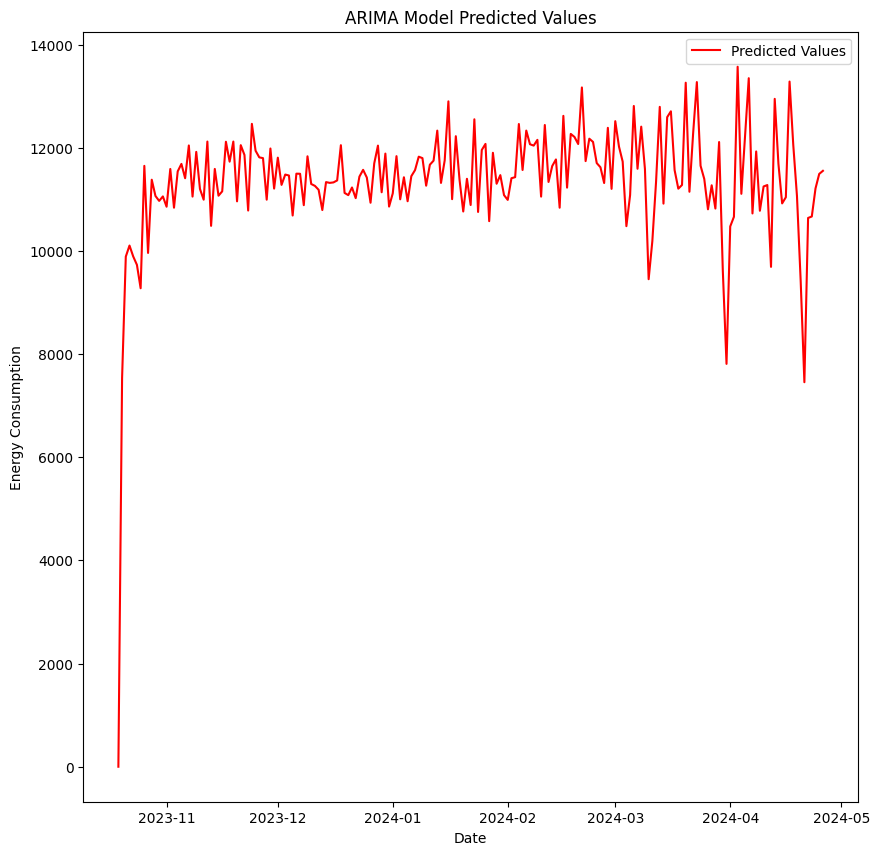

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, result_AR.fittedvalues, label='Predicted Values', color='red')

plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('ARIMA Model Predicted Values')

plt.legend()

plt.show()


In [ ]:
import pickle

# Assuming 'result_AR' is the trained ARIMA model
# Save the model to a file named 'arima_model.pkl'
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(result_AR, f)


In [ ]:
import pickle

# Load the ARIMA model from the file
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
